In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Github/
%cd hge_extended
%ls -a

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/hge_extended
build_hier.py  data/  hc.py   hge_extended_main_nb.ipynb  LICENSE    set_dissimilarity.py
clf_repo.py    .git/  hdc.py  hge_extended_main.py        README.md  utils.py


In [3]:
!pip install aeon
!pip install openml
!pip install prince
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.3 MB/s eta 0:00:00
  Created wheel for openml: filename=openml-0.14.2-py3-none-any.whl size=158699 sha256=0c6fa4847d60d92466be2f4acfa0ef6eb8cbe54cc9bf5727634504bd1ba1c4fd
  Stored in directory: /root/.cache/pip/wheels/2e/4e/af/5e721761d86375dbca82e63cc2470019e97815bc39f11451ea
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=efc563563cfe4a63113adb21a42a2f57ea0c641633aca85861a72b850ce1ade5
  Stored in directory: /root/.cache/pip/whee

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
import copy
from utils import prep_data, plot_dendrogram, get_score, get_significance
from set_dissimilarity import get_diss
from build_hier import build_tree
from clf_repo import clf_dict
import warnings
warnings.filterwarnings("ignore")

In [5]:
clf_name  = 'xgb'
dset_name = 'Glass'
diss_type = 'ccm'
out_type  = 'obs_vec'
link_type = 'hdc'
split_fun = 'kmeans'

k_run=10
te_size=0.2
plot_tree=True

hc_type='lcpn+f'
chain_type='prod'
eval_metric='f1'
multi_=False

In [6]:
# load dataset
(X,y),labels = prep_data(dset_name=dset_name,
                         repo='uci',
                         return_class_labels=True,
                         orig_split=True,
                         return_xy=True)

In [7]:
# Obtain dissimilarity
diss_ = get_diss(X,
                 y,
                 diss_type = diss_type,
                 out_type  = out_type)

In [8]:
tree_kwargs={'link_type':link_type,
             'input_type':out_type,
             'split_fun':split_fun}

# dendrogram display settings
n_row = k_run//5+1
if n_row>1:
    n_col = 5
else:
    n_col = k_run

run 0 f1 scores fc:0.6415, hc:0.7309, learning efficiency:1.1394
run 1 f1 scores fc:0.8080, hc:0.8080, learning efficiency:1.0000
run 2 f1 scores fc:0.7300, hc:0.7300, learning efficiency:1.0000
fc mean:0.7265±0.0680, hc mean:0.7563±0.0365, learning efficiency:1.0410 (p=0.3173)


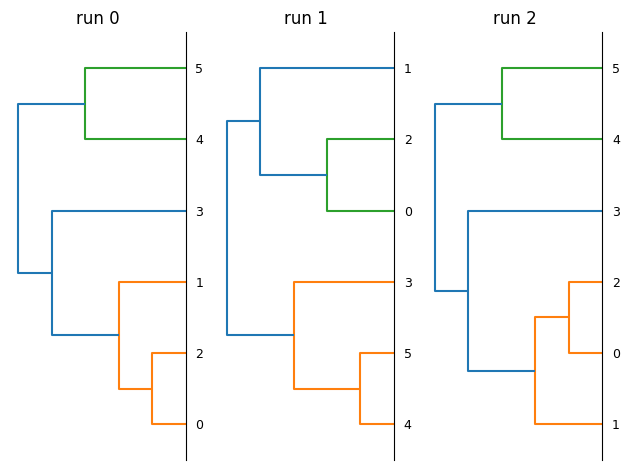

In [11]:
# Monte Carlo cross validation
scores_hc=[]
scores_fc=[]
for r_ in range(k_run):
    t_run=time()

    # splitting for Monte Carlo
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=te_size, random_state=r_, stratify=y)

    # building hieararchy in binary tree form
    tree_kwargs['y_test']=y_test
    tree, Z = build_tree(diss_, y_train, **tree_kwargs)

    if plot_tree:
        if r_==0:
            plt.close('all')
            plt.figure()
        plt.subplot(n_row,n_col,r_+1)
        plot_dendrogram(Z, orient="left", class_list=labels)
        ax=plt.gca()
        ax.spines[['left', 'top', 'bottom']].set_visible(False)
        plt.xticks([])
        plt.title(f'run {r_:d}')
        if r_==k_run-1:plt.tight_layout()

    # HC
    clf_base = copy.deepcopy(clf_dict[clf_name])
    tree.fit(clf_base, x_train, hc_type=hc_type, multi_process=multi_)
    tree.predict(x_test, hc_type=hc_type, chain_type=chain_type)
    score_hc = tree.score(eval_metric=eval_metric)
    scores_hc.append(score_hc)

    # FC
    clf_base.fit(x_train,y_train)
    y_pred = clf_base.predict(x_test)
    pred_proba_fc = clf_base.predict_proba(x_test)
    score_fc = get_score(y_test, y_pred=y_pred, pred_proba=pred_proba_fc, eval_metric=eval_metric)
    scores_fc.append(score_fc)

    # Display results
    print(f'run {r_} {eval_metric} scores fc:{score_fc:.4f}, hc:{score_hc:.4f}, learning efficiency:{score_hc/score_fc:.4f}')

le_mean, p_val, _ = get_significance(scores_hc,scores_fc)
score_fc_mean = np.mean(scores_fc)
score_hc_mean = np.mean(scores_hc)
print(f'fc mean:{score_fc_mean:.4f}\u00B1{np.std(scores_fc):.4f}, hc mean:{score_hc_mean:.4f}\u00B1{np.std(scores_hc):.4f}, learning efficiency:{le_mean:.4f} (p={p_val:.4f})')